In [1]:
import pandas as pd
import numpy as np
import re
from ast import literal_eval

import sys
sys.path.append('../scripts')
sys.path.append('../src')

from robot_arm import RobotArm, RobotArm2D, RobotArm3D
from task_info import TaskInfo, numpy_linspace

from PIBB_helper import qdotdot_gen
from pdff_kinematic_sim_funcs import get_traj_and_simulate2d, get_traj
import matplotlib.pyplot as plt
from pdff_kinematic_sim_funcs import PIBB
from pdff_kinematic_sim_funcs import gen_theta

# Load Data

In [2]:
pibb_data_df = pd.read_csv('../training_data/20220327_1108_pibb_2D.csv')
task_info_df = pd.read_csv('../training_data/20220327_1108_task_info.csv')

In [3]:

def task_info_from_df(df):
    return TaskInfo(
        robotarm = None, #TODO need to fix this
        lambda_min = df["lambda_min"].values[0],
        lambda_max = df["lambda_max"].values[0],
        B = df["B"].values[0],
        K = df["K"].values[0],
        N = df["N"].values[0],
        T = df["T"].values[0],
        h = df["h"].values[0],  # eliteness param
        dt = df["dt"].values[0],
        target_pos = df["target_pos"],
        w = df["w"].values[0],
        cs = df["cs"]
    )

def robot2D_from_df(df):
    return RobotArm2D(df["n_dims"], df["link_lenghts"])

task_info = task_info_from_df(task_info_df)

robot_arm = RobotArm2D(
    n_dims = 3,
    link_lengths = np.array([0.6, 0.3, 0.1])
)
task_info.robotarm = robot_arm

## Data Cleaning

In [4]:
def str_to_floats(angle_str):
    try:
        angle_floats = angle_str[1:len(angle_str)-1].strip().split(" ")
        angle_floats = [angle for angle in angle_floats if angle != ""]
        angle_floats = [float(angle) for angle in angle_floats]
    except Exception as ex:
        print(angle_str, angle_str[0], type(angle_str[0]))
    return angle_floats

In [5]:
# clean task info
target_pos = task_info_df.pop('target_pos')
target_pos_floats = []
for angles in target_pos:
    target_pos_floats.append(str_to_floats(angles))
target_pos_np = np.array(target_pos_floats)

cs = task_info_df.pop('cs')
cs_floats = []
for val in cs:
    cs_floats.append(str_to_floats(val))
cs_vals_np = np.array(cs_floats)

task_info.target_pos = target_pos_np[0]
task_info.cs = cs_vals_np[0]

In [6]:
from sys import platform

delimiter = "\r\n " if platform == "win32" else "\n "

# reshape x target
x_target = pibb_data_df['x_target']
x_target_np = x_target.to_numpy()
x_target = np.reshape(x_target_np, (x_target_np.shape[0], 1))

# rehsape y target
y_target = pibb_data_df['y_target']
y_target_np = y_target.to_numpy()
y_target = np.reshape(y_target_np, (y_target_np.shape[0], 1))

# reshape joint angles

joint_angles = pibb_data_df['init_joint_angles']
joint_angle_floats = []
for angles in joint_angles:
    joint_angle_floats.append(str_to_floats(angles))
joint_angle_np = np.array(joint_angle_floats)
joint_angles = joint_angle_np

# reshape theta

theta = pibb_data_df['Theta']
temp_theta = np.zeros(shape=(len(pibb_data_df), task_info.B, task_info.N)) #670 for each element, 2 for x & y, 5 for gaussian basis functions
for t in range(0, len(temp_theta)):
    if theta[t].startswith("[") and theta[t].endswith("]"):
        temp = theta[t][1:-1]
    else:
        print("Error")
    tp = temp.split(delimiter)
    for i in range(0, len(tp)):
        temp_array = str_to_floats(tp[i])
        temp_theta[t][i] = temp_array
   
theta = temp_theta

print("Input sizes are: \n", "joint angles: ", str(joint_angles.shape), "\nx_target: ",
 str(x_target.shape), "\ny_target: ", str(y_target.shape))
print("Output size is:\n theta: ", str(theta.shape))

Input sizes are: 
 joint angles:  (128, 3) 
x_target:  (128, 1) 
y_target:  (128, 1)
Output size is:
 theta:  (128, 5, 3)


In [7]:
# Concatenate all input features into a single matrix
concat_input = np.concatenate([joint_angles, x_target, y_target], axis=1)
print(concat_input.shape)

(128, 5)


In [8]:
# Flatten theta for each sample into a vector
flatten_theta = np.zeros(shape=(theta.shape[0], theta.shape[1]*theta.shape[2]))
for i in range(0, len(flatten_theta)):
    flatten_theta[i] = theta[i].flatten()
print(flatten_theta.shape)

(128, 15)


# Scipy Interpolation

In [9]:
from scipy.interpolate import NearestNDInterpolator

In [10]:
interp = NearestNDInterpolator(concat_input, flatten_theta)

# Visualize Results

In [12]:
preds_dict = {"input":[], "pred_theta":[], "theta":[]}
for r in range(128):
    pred_t = interp(concat_input[r])
    preds_dict["input"].append(concat_input[r])
    preds_dict["pred_theta"].append(pred_t[0])
    preds_dict["theta"].append(flatten_theta[r])

In [13]:
preds_df = pd.DataFrame.from_dict(preds_dict)

In [14]:
preds_df.head()

input  \
0  [2.76355729, 2.41565672, 0.54568809, -0.956940...   
1  [2.76355729, 2.41565672, 0.54568809, -0.970031...   
2  [2.76355729, 2.41565672, 0.54568809, -0.980785...   
3  [2.76355729, 2.41565672, 0.54568809, -0.989176...   
4  [2.76355729, 2.41565672, 0.54568809, -0.995184...   

                                          pred_theta  \
0  [1.81189853, -10.02668728, -2.1113445, 0.54975...   
1  [2.12982639, -7.67435066, -0.77855516, 0.76162...   
2  [1.8193199, -7.61468219, -0.36191638, 0.680671...   
3  [1.6086637, -7.61382017, -0.52626217, 0.552868...   
4  [1.2407587, -7.64572019, -0.33870223, 0.639476...   

                                               theta  
0  [2.14808196, -7.67950268, -1.32201481, 0.52117...  
1  [2.12982639, -7.67435066, -0.77855516, 0.76162...  
2  [1.8193199, -7.61468219, -0.36191638, 0.680671...  
3  [1.6086637, -7.61382017, -0.52626217, 0.552868...  
4  [1.2407587, -7.64572019, -0.33870223, 0.639476...

In [25]:
import random
#Generate 5 random numbers between 10 and 30
randomlist = random.sample(range(0, 127), 5)
print(randomlist)

[37, 109, 21, 15, 104]


In [26]:
from IPython import display

def animate_result(result_index):

    print("input: " + str(preds_df["input"][result_index]))
    print("predicted: " + str(preds_df["pred_theta"][result_index]))
    print("actual: " + str(preds_df["theta"][result_index]))

    theta_reshaped = np.reshape(preds_df["pred_theta"][result_index], ( task_info.B, task_info.N))
    print(theta_reshaped)

    test_input = preds_df["input"][result_index]
    target_pt = [test_input[-2], test_input[-1]]
    init_condit = [list(test_input[:3]), [0,0,0]]

    print(target_pt)
    print(init_condit)

    predicted_qdotdot = np.array(  
        [
            qdotdot_gen(task_info, theta_reshaped, t) for t in numpy_linspace(0, task_info.T, task_info.dt)
        ]  
        )
        
    # print(predicted_qdotdot.shape)
    time_steps, q, qdot, gen_qdotdot, ani = get_traj_and_simulate2d(
        qdotdot     = predicted_qdotdot, 
        robot_arm   = robot_arm, 
        x_goal      = target_pt, 
        init_condit = init_condit, 
        dt          = task_info.dt
        )

    video = ani.to_jshtml(fps = 60)
    # video = ani.to_html5_video() # to save as mp4, use this
    html = display.HTML(video)
    display.display(html)

input: [ 2.76355729  2.41565672  0.54568809 -0.04906767  0.99879546]
predicted: [-5.28690567 -5.96859413 -0.29205196 -1.35022015 -1.56850728 -3.64469565 -1.41521735 -7.44108656  0.16176706 -0.62107118 -0.04978943 -2.46481357  0.48209476  0.94350102  0.45595682]
actual: [-5.28690567 -5.96859413 -0.29205196 -1.35022015 -1.56850728 -3.64469565 -1.41521735 -7.44108656  0.16176706 -0.62107118 -0.04978943 -2.46481357  0.48209476  0.94350102  0.45595682]
[[-5.28690567 -5.96859413 -0.29205196]
 [-1.35022015 -1.56850728 -3.64469565]
 [-1.41521735 -7.44108656  0.16176706]
 [-0.62107118 -0.04978943 -2.46481357]
 [ 0.48209476  0.94350102  0.45595682]]
[-0.049067674327418, 0.9987954562051724]
[[2.76355729, 2.41565672, 0.54568809], [0, 0, 0]]


input: [ 2.76355729  2.41565672  0.54568809  0.80320753 -0.5956993 ]
predicted: [ 7.26605636 -9.92033879 -3.61929684  6.33718055 -1.82923165  1.50188436  2.62941538 -0.02819106 -3.19272139  3.11145039  1.40115329  0.11977187  2.59673406 -0.19922134  2.65887937]
actual: [ 7.26605636 -9.92033879 -3.61929684  6.33718055 -1.82923165  1.50188436  2.62941538 -0.02819106 -3.19272139  3.11145039  1.40115329  0.11977187  2.59673406 -0.19922134  2.65887937]
[[ 7.26605636 -9.92033879 -3.61929684]
 [ 6.33718055 -1.82923165  1.50188436]
 [ 2.62941538 -0.02819106 -3.19272139]
 [ 3.11145039  1.40115329  0.11977187]
 [ 2.59673406 -0.19922134  2.65887937]]
[0.8032075314806449, -0.5956993044924331]
[[2.76355729, 2.41565672, 0.54568809], [0, 0, 0]]


input: [ 2.76355729  2.41565672  0.54568809 -0.74095113  0.67155895]
predicted: [-2.21490486 -6.82807922 -1.19077609 -0.12679117 -0.62748516 -3.35320117 -1.65552251 -6.91808913  0.2683768   0.23917102  0.0773114  -1.91574447  1.99269134  0.57046994 -0.10059357]
actual: [-2.21490486 -6.82807922 -1.19077609 -0.12679117 -0.62748516 -3.35320117 -1.65552251 -6.91808913  0.2683768   0.23917102  0.0773114  -1.91574447  1.99269134  0.57046994 -0.10059357]
[[-2.21490486 -6.82807922 -1.19077609]
 [-0.12679117 -0.62748516 -3.35320117]
 [-1.65552251 -6.91808913  0.2683768 ]
 [ 0.23917102  0.0773114  -1.91574447]
 [ 1.99269134  0.57046994 -0.10059357]]
[-0.7409511253549591, 0.6715589548470181]
[[2.76355729, 2.41565672, 0.54568809], [0, 0, 0]]


input: [ 2.76355729  2.41565672  0.54568809 -0.90398929  0.42755509]
predicted: [-1.73623866 -7.59496562 -0.23186181  0.87027358 -0.55731371 -3.73645223 -1.23121822 -6.29383135  0.87251544  0.9521015   0.14768603 -2.59179391  1.21517426  1.25806764 -0.86422595]
actual: [-1.73623866 -7.59496562 -0.23186181  0.87027358 -0.55731371 -3.73645223 -1.23121822 -6.29383135  0.87251544  0.9521015   0.14768603 -2.59179391  1.21517426  1.25806764 -0.86422595]
[[-1.73623866 -7.59496562 -0.23186181]
 [ 0.87027358 -0.55731371 -3.73645223]
 [-1.23121822 -6.29383135  0.87251544]
 [ 0.9521015   0.14768603 -2.59179391]
 [ 1.21517426  1.25806764 -0.86422595]]
[-0.9039892931234432, 0.427555093430282]
[[2.76355729, 2.41565672, 0.54568809], [0, 0, 0]]


input: [ 2.76355729  2.41565672  0.54568809  0.63439328 -0.77301045]
predicted: [  6.97609604 -10.66638258  -3.17701427   5.79713474  -1.22811353   1.24054843   1.63760382   0.19399567  -2.98818665   2.73175904   1.63226554  -0.2011452    2.41411999  -0.33492061   2.99557258]
actual: [  6.97609604 -10.66638258  -3.17701427   5.79713474  -1.22811353   1.24054843   1.63760382   0.19399567  -2.98818665   2.73175904   1.63226554  -0.2011452    2.41411999  -0.33492061   2.99557258]
[[  6.97609604 -10.66638258  -3.17701427]
 [  5.79713474  -1.22811353   1.24054843]
 [  1.63760382   0.19399567  -2.98818665]
 [  2.73175904   1.63226554  -0.2011452 ]
 [  2.41411999  -0.33492061   2.99557258]]
[0.6343932841636455, -0.7730104533627368]
[[2.76355729, 2.41565672, 0.54568809], [0, 0, 0]]


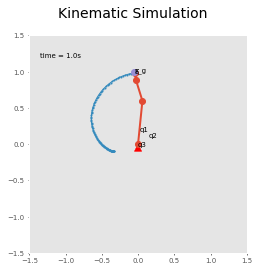

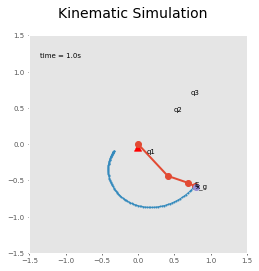

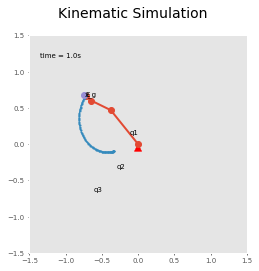

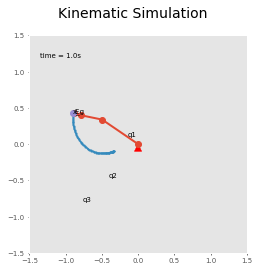

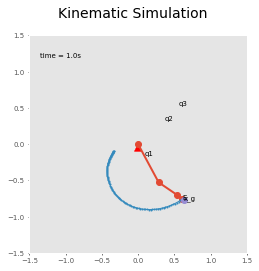

In [27]:
for r in randomlist:
    animate_result(r)

# Unknown Points

In [60]:
unknown_target = [2.76355729, 2.41565672, 0.54568809, -0.707, -0.707]
pred_unknown = interp(unknown_target)

In [61]:
unknown_reshaped = pred_unknown.reshape(task_info.B, task_info.N)
print(unknown_reshaped.shape)

(5, 3)


In [62]:
print(unknown_reshaped)

[[ 3.29222594e+00 -1.26186471e+01 -1.19180430e+00]
 [ 1.62764103e+00  4.99907101e-02  1.18598168e-01]
 [ 9.03885599e-01  1.41695795e+00 -1.69891854e+00]
 [ 1.23973296e+00 -6.57882672e-01 -3.38019979e-02]
 [ 1.70294540e+00  2.94653268e-03  1.70708652e+00]]


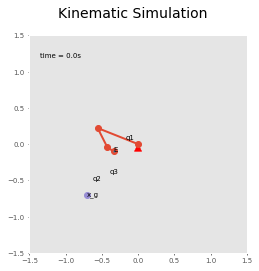

In [63]:

predicted_qdotdot = np.array(  
    [
        qdotdot_gen(task_info, unknown_reshaped, t) for t in numpy_linspace(0, task_info.T, task_info.dt)
    ]  
    )
    
# print(predicted_qdotdot.shape)
time_steps, q, qdot, gen_qdotdot, ani = get_traj_and_simulate2d(
    qdotdot     = predicted_qdotdot, 
    robot_arm   = robot_arm, 
    x_goal      = [unknown_target[-2], unknown_target[-1]], 
    init_condit = [unknown_target[0:3], [0,0,0]], 
    dt          = task_info.dt
    )

In [64]:
from IPython import display
video = ani.to_jshtml(fps = 60)
# video = ani.to_html5_video() # to save as mp4, use this
html = display.HTML(video)
display.display(html)